<a href="https://colab.research.google.com/github/Appachan10/Acoustic-fence/blob/main/Animal_voice_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import librosa
audio_data = '/content/drive/MyDrive/Train/1.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [11]:
librosa.load(audio_data, sr=44100) #resampling

(array([-0.01441414, -0.01741881, -0.01688657, ...,  0.01013231,
         0.00745253,  0.00318813], dtype=float32), 44100)

In [12]:
#using wild boar sound
import IPython.display as ipd  #Using,IPython.display.Audio you can play the audio in your jupyter notebook
ipd.Audio(audio_data)


We can plot the audio array using librosa.display.waveplot


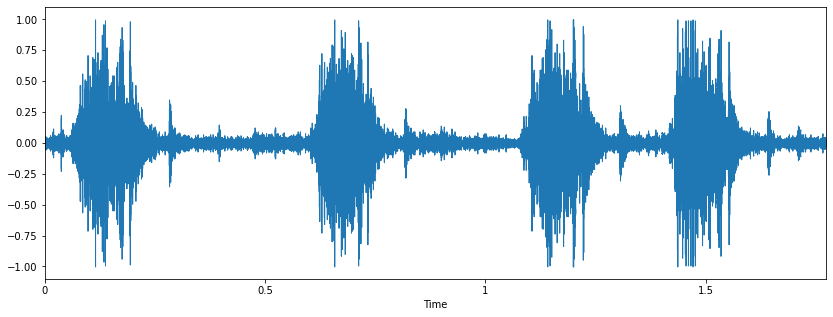

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### **Spectrogram**

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using. librosa.display.specshow.

' STFT converts signals such that we can know the amplitude of the given frequency at a given time.\n Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.\n.specshow is used to display a spectrogram.'

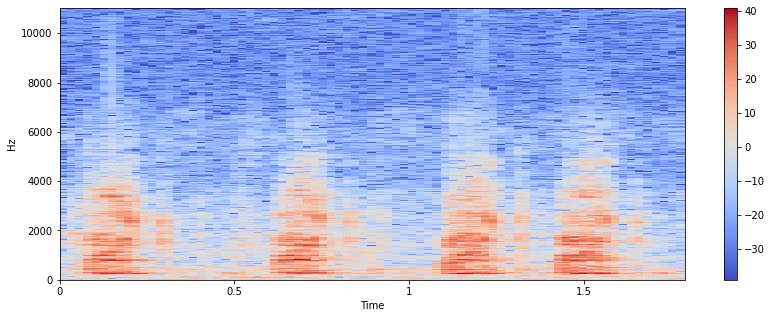

In [14]:
X = librosa.stft(x)  #converts data into short term Fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
''' STFT converts signals such that we can know the amplitude of the given frequency at a given time.
 Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.
.specshow is used to display a spectrogram.'''

The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

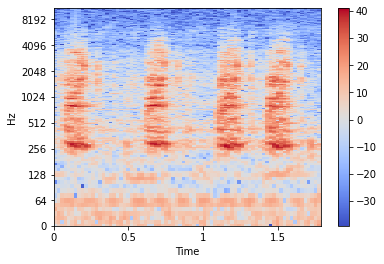

In [15]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Animal voice classification using CNN


In [16]:
# loading all the required libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

Converting the audio data files into PNG format images or basically extracting the Spectrogram for every Audio. We are useing librosa python library to extract Spectrogram for every audio file.



In [ ]:
animals = ['Boar','Elephant','Monkey']
for a in animals:
    pathlib.Path(f'img_data/{a}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/MyDrive/Wild animal sounds/{a}'):
        animalVoice = f'/content/drive/MyDrive/Wild animal sounds/{a}/{filename}'
        y, sr = librosa.load(animalVoice, mono=True, duration=5)
        print(y.shape)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='viridis', sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{a}/{filename[:-3].replace(".", "")}.png')  #directory img_data containing all the images categorized in the Wild animal sounds
        plt.clf()

In [30]:
pip install split-folders

split the data into the train set and test set


In [33]:
import splitfolders
splitfolders.ratio('./img_data/', output="./data", seed=1337, ratio=(.8, .2))

Copying files: 70 files [00:00, 3459.42 files/s]


## Image Augmentation

In [34]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2, #to apply zoom
        horizontal_flip=True) # image will be flipper horiztest_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
training_set = train_datagen.flow_from_directory('./data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = train_datagen.flow_from_directory('./data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )

Found 55 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Creating a Convolutional Neural Network:

In [39]:
model = Sequential()
input_shape=(64, 64, 3)#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))#Output layer
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

training the network using Stochastic Gradient Descent(SGD):

In [45]:
epochs = 50
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.fit_generator(training_set,
                    steps_per_epoch=100,
                    epochs=50,validation_data=test_set,
                    validation_steps=200)

In [ ]:
#Model Evaluation
model.evaluate_generator(generator=test_set, steps=50)

 make some predictions on the test data set

In [ ]:
test_set.reset()
pred = model.predict_generator(test_set, steps=50, verbose=1)

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

checking the size

In [ ]:
print(len(filename, len(predictions)))

saving the results to a CSV file:

Append filenames and predictions to a single pandas dataframe as two separate columns.

In [ ]:
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions},orient='index')
results.to_csv("prediction_results.csv",index=False)